In [1]:
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import pandas_profiling
import numpy as np
import warnings
import sklearn

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn import linear_model
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

/opt/conda/anaconda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button style="color:"black";right:75%;" onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [3]:
######################################################################## ALL USER DEFINED FUNCTION ARE LOGGED HERE #############################################################################
################################################################################################################################################################################################

# calculate rmse scores
def rmse(pred_test, y_test):
    return - np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# get names of all categorical data present in data
def get_index_of_categorical_columns(df):
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))


def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

#### **Load IPL Analytical Dataset v10.4.0**

In [4]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################
####### Load ADS using name and path
#### Put name of the file as ads_name : name_of_my_ads
### Put the path is ads name : aes-analytics-0001-notebooks/Outage Restoration/Offshore_Gourav/CSV repo/

load_ads = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_V10.4_IQR_08092020.csv')
print('\n')
display(load_ads.head())
print('\n')
print('\n')
print(list(load_ads.columns))

,DNI_EQUIP_TYPE,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Priority_Customer_Qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,mslPresAvg,mslPresMax,mslPresMin,precip,radSolarAvg,radSolarMax,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio
0,SSUB,4,177.0,1.0,False,15.0000,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE3,7,1,5,2,1,0.707107,7.071068e-01,1.0,0,0,0,0,0,0,0,0,0,0,Monday,False,1.0,1.0,ARL.,92.0,100.0,44.0,33.9,39.5,30.0,30.3,36.7,24.3,38.5,43.7,34.5,1016.4,1026.0,1008.9,0.0,28.5,125.4,684.3,83.3,90.3,79.3,986.8,995.8,980.1,0.0,4.2,5.2,3.6,38.5,43.7,34.5,36.6,41.7,32.8,30.3,36.7,24.3,269.0,269.0,267.0,16.8,20.3,8.8,17.0,20.6,8.9,14.4,17.8,6.7,9.2,11.1,15.7,56.0,11.0,1.138714,1.016019
1,FUSE,1,5.0,0.0,True,108.1667,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE4,7,1,5,2,1,0.866025,-5.000000e-01,2.0,0,0,0,0,1,1,1,1,1,1,Monday,False,2.0,2.0,MILL,93.0,100.0,43.0,33.2,39.1,29.5,29.6,36.3,23.5,37.9,43.2,34.0,1016.9,1026.2,1009.3,0.0,29.0,127.2,695.3,83.0,90.0,79.0,986.8,995.7,980.1,0.0,4.1,5.2,3.5,37.9,43.2,34.0,36.0,41.3,32.2,29.6,36.3,23.5,270.0,271.0,268.0,16.8,20.2,8.7,16.9,20.5,8.8,14.4,17.8,6.7,9.2,11.1,15.6,57.0,11.0,1.139241,1.015917
2,1TBOH,2,6.0,0.0,True,39.6000,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE4,7,1,5,2,1,0.70710





['DNI_EQUIP_TYPE', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWIT

#### **Columns with Categorical Values**

In [5]:
object_columns = load_ads.loc[:, (load_ads.dtypes == object) | (load_ads.dtypes == bool)]
print(list(object_columns.columns))

['DNI_EQUIP_TYPE', 'DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', '

#### **Dummifying Categorical Variables**

In [6]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################

select_columns_from_ads = ['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG',
                           'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                           'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 
                           'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 
                           'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG',
                           'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                           'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 
                           'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 
                           'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0',
                           'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 'ZONE', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY',
                           'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 
                           'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr',
                           'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Weekday', 'Weekend_flag',
                           'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'Dispatch_Location', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 
                           'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg',
                           'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 
                           'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBulbMax',
                           'wetBulbMin', 'windChillAvg', 'windChillMax', 'windChillMin', 'windDir100mAvg', 'windDir80mAvg', 'windDirAvg', 'windSpd100mAvg',
                           'windSpd100mMax', 'windSpd100mMin', 'windSpd80mAvg', 'windSpd80mMax', 'windSpd80mMin', 'windSpdAvg', 'windSpdMax', 'windSpdMin', 
                           'tempRange', 'windSpdRange', 'sfcPresRange', 'cldCvrRange', 'relHumRange', 'relHumRatio', 'sfcPresRatio']

ads = load_ads[select_columns_from_ads]

ads = pd.get_dummies(ads, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

In [7]:
# print list of columns present in the ads and drop na's from the dataset
print(list(ads.columns))
ads.dropna(inplace=True)
print(ads.shape)

['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'TTR', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr', 'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg', 'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBu

#### **Target Variable Analysis: Is it Normal?**

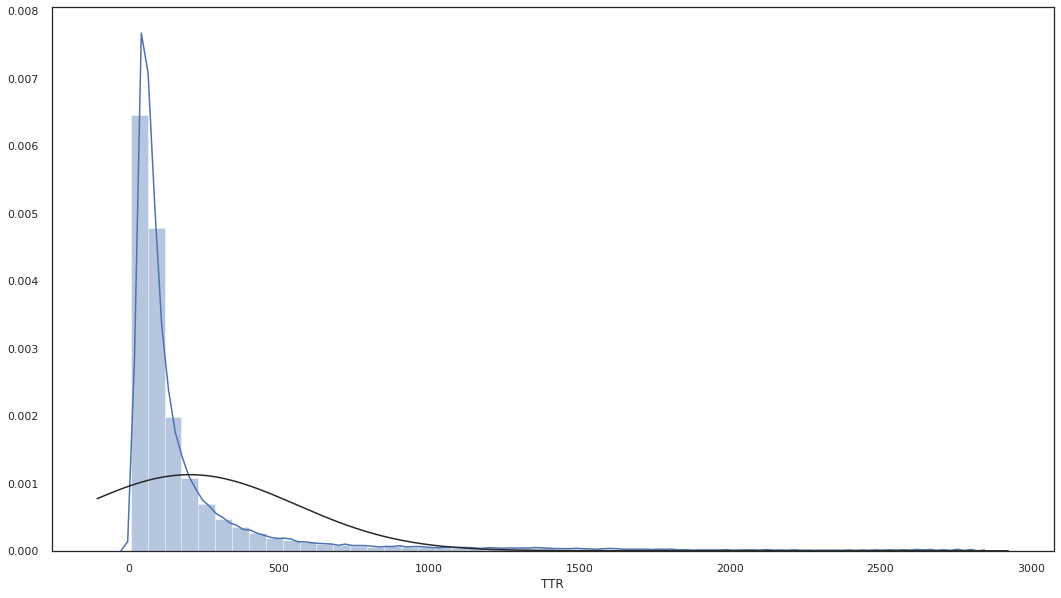

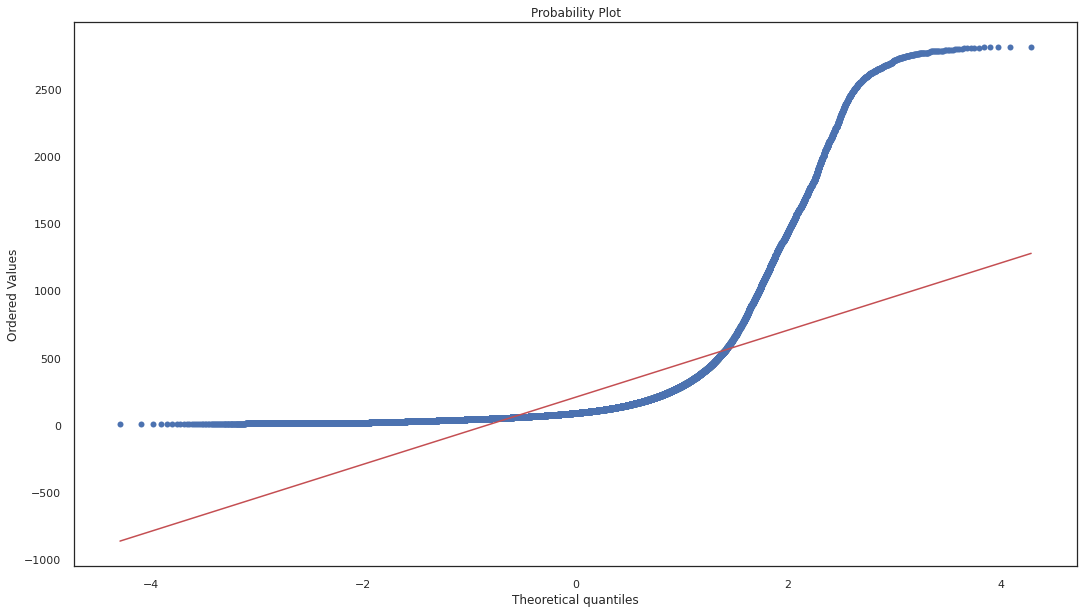

In [8]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(16,10)})
sns.set_style("white")

sns.distplot(ads['TTR'],fit=norm);
fig = plt.figure()
print('\n')
print('\n')
res = stats.probplot(ads['TTR'], plot=plt)

#### **Log Transformation of Tanget Variable (TTR)**

In [9]:
# Apply log e tranformation to the dataset
ads['TTR'] = np.log(ads['TTR'])

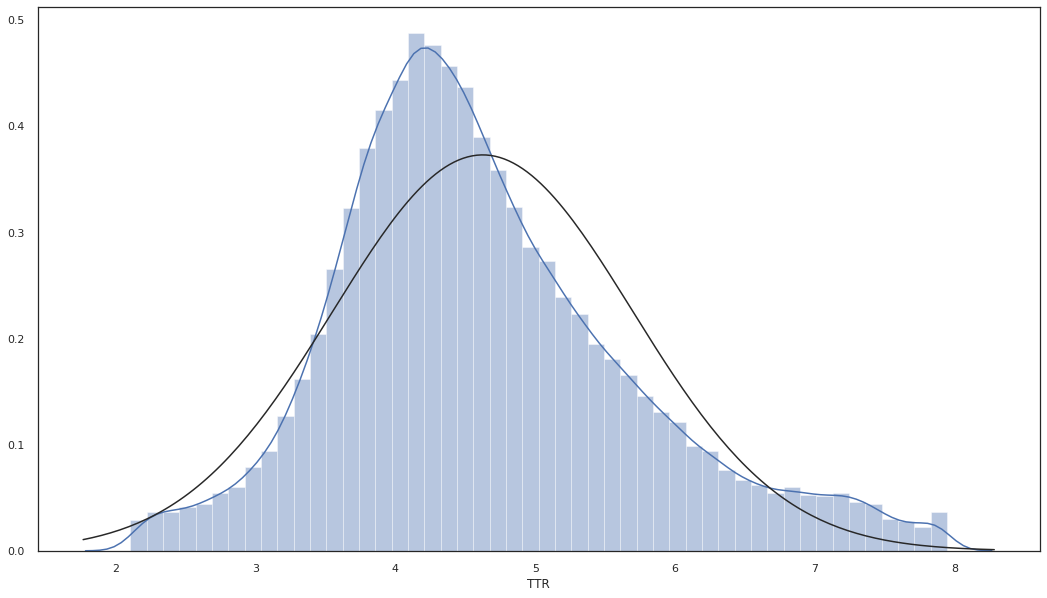

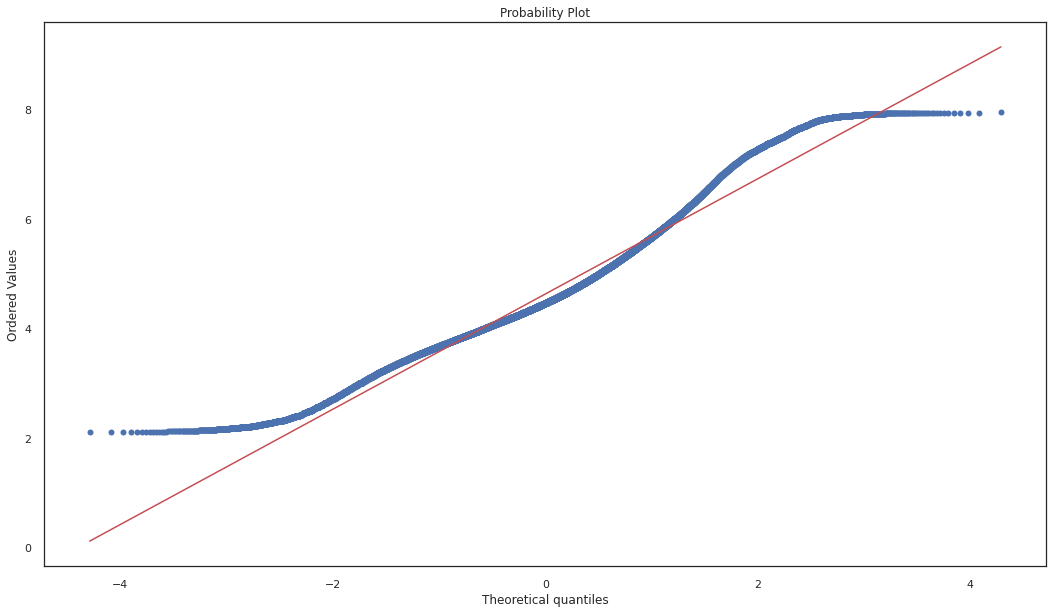

In [10]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(16,10)})
sns.set_style("white")

sns.distplot(ads['TTR'],fit=norm);
fig = plt.figure()
print('\n')
print('\n')
res = stats.probplot(ads['TTR'], plot=plt)

In [11]:
%%time

#########################################################################################################################################################################################################
######################################################################## FEATURE SELECTION : MAX VOTING REGIME ##########################################################################################

X = ads.drop(['TTR'],axis=1)
y = ads['TTR']


lasso = LassoCV()
lasso.fit(X, y)
pls = PLSRegression(n_components=15)
pls.fit(X.values, y.values)
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X,y)
xg = xgb.XGBRegressor(n_jobs=-1,verbose=2)
xg.fit(X,y)

CPU times: user 20min 9s, sys: 35.3 s, total: 20min 44s
Wall time: 5min 1s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
lasso_reg = pd.DataFrame({'Features': X.columns, 'Importance_Score_Lasso': lasso.coef_}).sort_values(by='Importance_Score_Lasso',ascending=False)
pls_reg = pd.DataFrame({'Features': X.columns, 'Importance_Score_PLS': pls.coef_.ravel()}).sort_values(by='Importance_Score_PLS',ascending=False)
rftrees = pd.DataFrame({'Features': X.columns, 'Importance_Score_Random_Forest': rf.feature_importances_}).sort_values(by='Importance_Score_Random_Forest',ascending=False)
xgboost = pd.DataFrame({'Features': X.columns, 'Importance_Score_XGBoost': xg.feature_importances_}).sort_values(by='Importance_Score_XGBoost',ascending=False)


lasso_reg.reset_index(drop=True,inplace=True)
pls_reg.reset_index(drop=True,inplace=True)
rftrees.reset_index(drop=True,inplace=True)
xgboost.reset_index(drop=True,inplace=True)

lasso_reg = lasso_reg.head(15)
pls_reg = pls_reg.head(15)
rftrees = rftrees.head(15)
xgboost = xgboost.head(15)

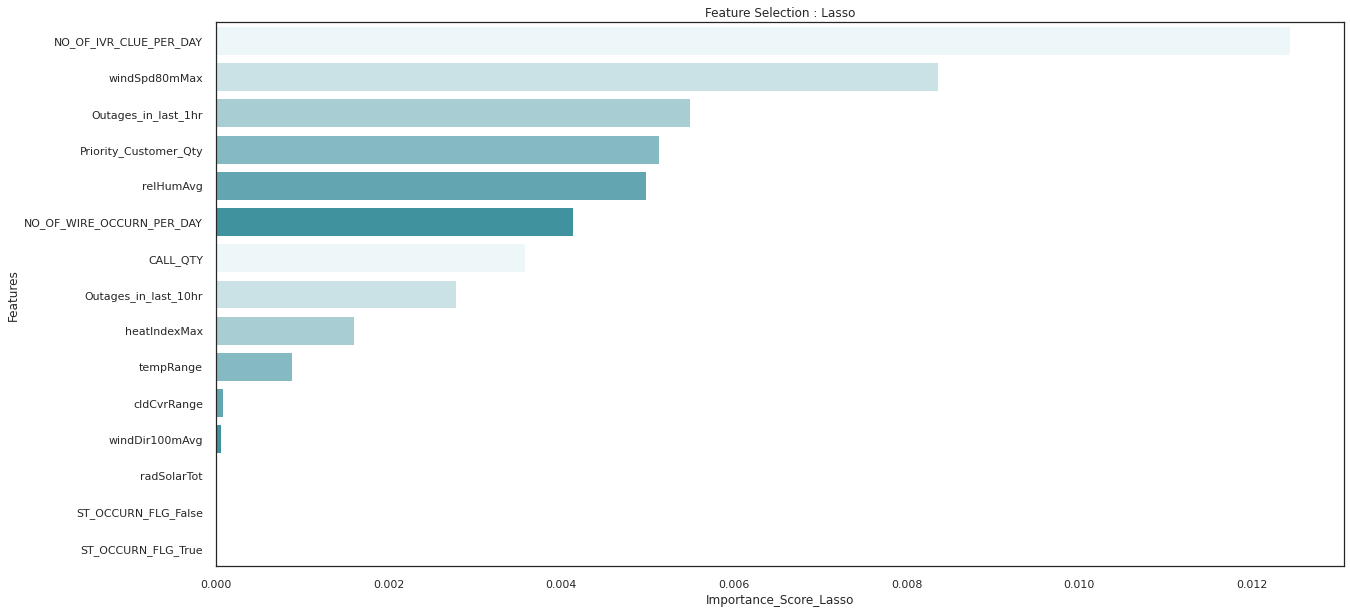

In [13]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_Lasso", y="Features", data=lasso_reg, palette = sns.light_palette((210, 90, 60), input="husl")).set_title('Feature Selection : Lasso')

In [14]:
print('\n')
print('\n')
display(lasso_reg)
print('\n')
print('\n')

,Features,Importance_Score_Lasso
0,NO_OF_IVR_CLUE_PER_DAY,0.012442
1,windSpd80mMax,0.008362
2,Outages_in_last_1hr,0.005486
3,Priority_Customer_Qty,0.005132
4,relHumAvg,0.004984
5,NO_OF_WIRE_OCCURN_PER_DAY,0.004136
6,CALL_QTY,0.003578
7,Outages_in_last_10hr,0.002783
8,heatIndexMax,0.001594
9,tempRange,0.000883


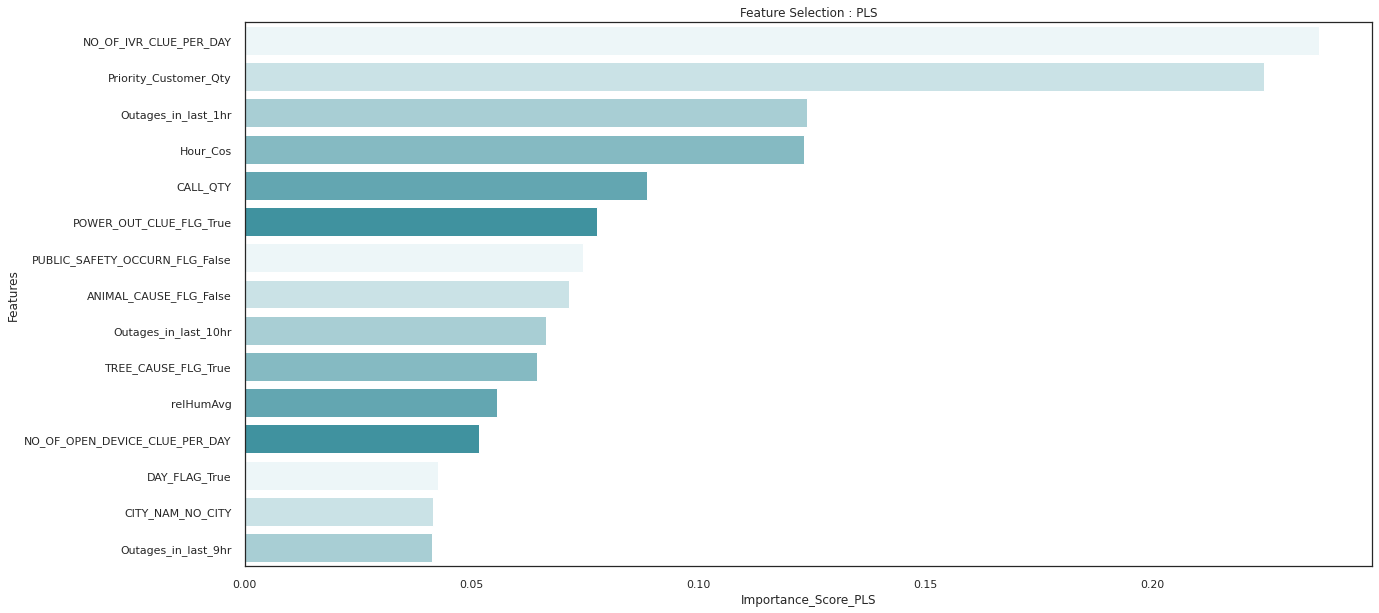

In [15]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_PLS", y="Features", data=pls_reg , palette = sns.light_palette((210, 90, 60), input="husl")).set_title('Feature Selection : PLS')

In [16]:
print('\n')
print('\n')
display(pls_reg)
print('\n')
print('\n')

,Features,Importance_Score_PLS
0,NO_OF_IVR_CLUE_PER_DAY,0.236486
1,Priority_Customer_Qty,0.224484
2,Outages_in_last_1hr,0.123908
3,Hour_Cos,0.123097
4,CALL_QTY,0.088688
5,POWER_OUT_CLUE_FLG_True,0.077578
6,PUBLIC_SAFETY_OCCURN_FLG_False,0.074411
7,ANIMAL_CAUSE_FLG_False,0.071317
8,Outages_in_last_10hr,0.066377
9,TREE_CAUSE_FLG_True,0.064348


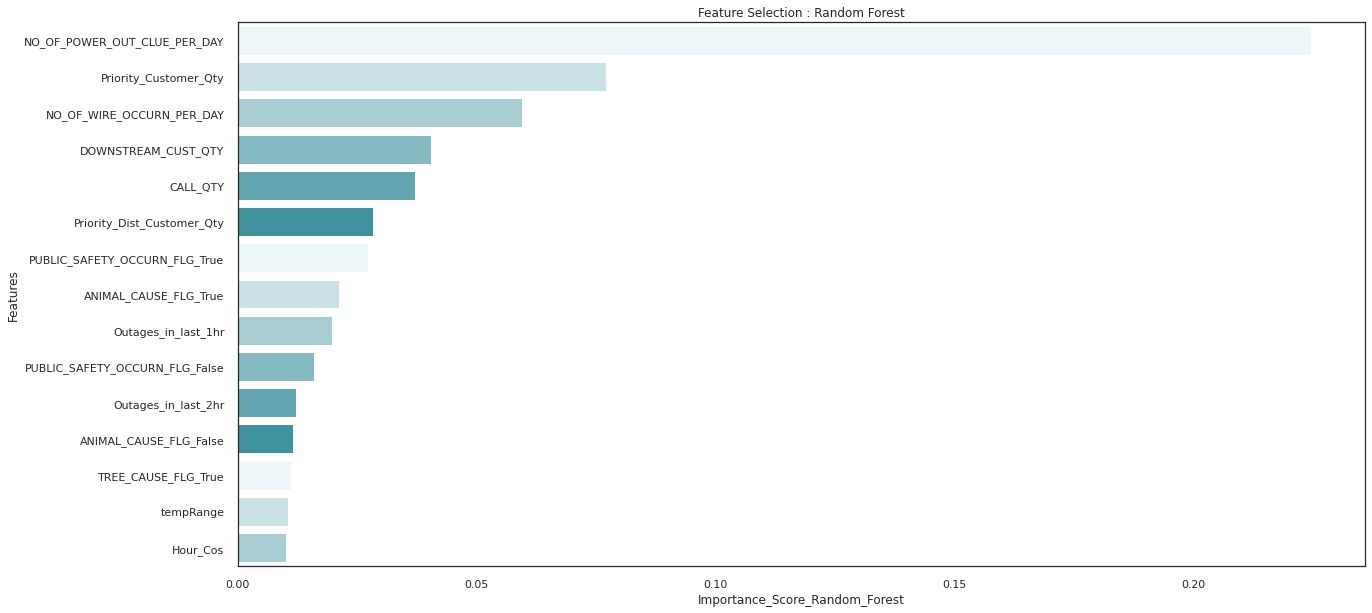

In [17]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_Random_Forest", y="Features", data=rftrees, palette = sns.light_palette((210, 90, 60), input="husl")).set_title('Feature Selection : Random Forest')

In [18]:
print('\n')
print('\n')
display(rftrees)
print('\n')
print('\n')

,Features,Importance_Score_Random_Forest
0,NO_OF_POWER_OUT_CLUE_PER_DAY,0.224643
1,Priority_Customer_Qty,0.076983
2,NO_OF_WIRE_OCCURN_PER_DAY,0.059564
3,DOWNSTREAM_CUST_QTY,0.040449
4,CALL_QTY,0.037091
5,Priority_Dist_Customer_Qty,0.028284
6,PUBLIC_SAFETY_OCCURN_FLG_True,0.027302
7,ANIMAL_CAUSE_FLG_True,0.021160
8,Outages_in_last_1hr,0.019835
9,PUBLIC_SAFETY_OCCURN_FLG_False,0.015905


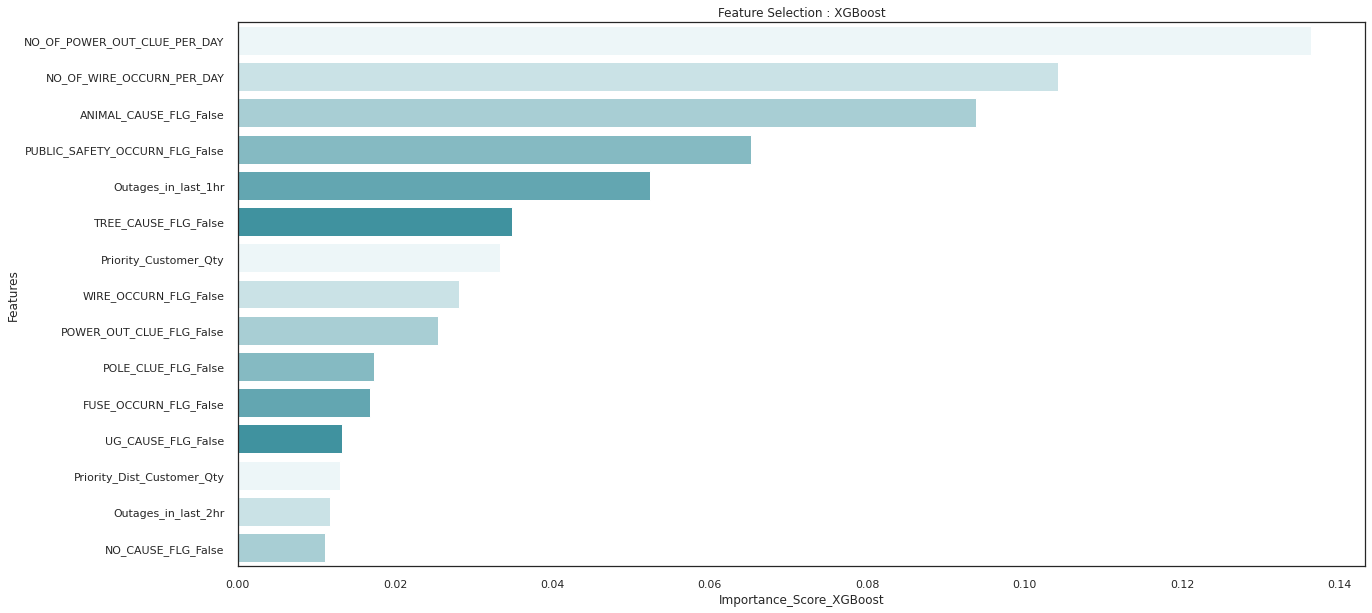

In [19]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.barplot(x="Importance_Score_XGBoost", y="Features", data=xgboost, palette = sns.light_palette((210, 90, 60), input="husl")).set_title('Feature Selection : XGBoost')

In [20]:
print('\n')
print('\n')
display(xgboost)
print('\n')
print('\n')

,Features,Importance_Score_XGBoost
0,NO_OF_POWER_OUT_CLUE_PER_DAY,0.136459
1,NO_OF_WIRE_OCCURN_PER_DAY,0.104273
2,ANIMAL_CAUSE_FLG_False,0.093799
3,PUBLIC_SAFETY_OCCURN_FLG_False,0.065253
4,Outages_in_last_1hr,0.052365
5,TREE_CAUSE_FLG_False,0.034891
6,Priority_Customer_Qty,0.033330
7,WIRE_OCCURN_FLG_False,0.028109
8,POWER_OUT_CLUE_FLG_False,0.025411
9,POLE_CLUE_FLG_False,0.017331


In [23]:
final_features = do_union(list(xgboost.Features), list(rftrees.Features), list(lasso_reg.Features), list(pls_reg.Features))

print('\n')
print('\n')

display(final_features)
print('\n')
print(len(final_features), "No. of Features Selected")


print('\n')
print('\n')

['TREE_CAUSE_FLG_True',
 'POLE_CLUE_FLG_False',
 'Outages_in_last_2hr',
 'DAY_FLAG_True',
 'relHumAvg',
 'FUSE_OCCURN_FLG_False',
 'windSpd80mMax',
 'DOWNSTREAM_CUST_QTY',
 'Hour_Cos',
 'radSolarTot',
 'CITY_NAM_NO_CITY',
 'WIRE_OCCURN_FLG_False',
 'tempRange',
 'Priority_Dist_Customer_Qty',
 'NO_OF_WIRE_OCCURN_PER_DAY',
 'windDir100mAvg',
 'cldCvrRange',
 'POWER_OUT_CLUE_FLG_True',
 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY',
 'UG_CAUSE_FLG_False',
 'NO_OF_POWER_OUT_CLUE_PER_DAY',
 'PUBLIC_SAFETY_OCCURN_FLG_False',
 'ANIMAL_CAUSE_FLG_False',
 'TREE_CAUSE_FLG_False',
 'Outages_in_last_9hr',
 'PUBLIC_SAFETY_OCCURN_FLG_True',
 'Outages_in_last_1hr',
 'heatIndexMax',
 'ST_OCCURN_FLG_True',
 'Priority_Customer_Qty',
 'NO_CAUSE_FLG_False',
 'NO_OF_IVR_CLUE_PER_DAY',
 'POWER_OUT_CLUE_FLG_False',
 'CALL_QTY',
 'ANIMAL_CAUSE_FLG_True',
 'Outages_in_last_10hr',
 'ST_OCCURN_FLG_False']



37 No. of Features Selected






In [24]:
ads_v1 = ads[final_features]
ads_v1['TTR'] = ads['TTR']
print('\n')
print('\n')
display(ads_v1.head())
print('\n')
print('\n')

,TREE_CAUSE_FLG_True,POLE_CLUE_FLG_False,Outages_in_last_2hr,DAY_FLAG_True,relHumAvg,FUSE_OCCURN_FLG_False,windSpd80mMax,DOWNSTREAM_CUST_QTY,Hour_Cos,radSolarTot,CITY_NAM_NO_CITY,WIRE_OCCURN_FLG_False,tempRange,Priority_Dist_Customer_Qty,NO_OF_WIRE_OCCURN_PER_DAY,windDir100mAvg,cldCvrRange,POWER_OUT_CLUE_FLG_True,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,UG_CAUSE_FLG_False,NO_OF_POWER_OUT_CLUE_PER_DAY,PUBLIC_SAFETY_OCCURN_FLG_False,ANIMAL_CAUSE_FLG_False,TREE_CAUSE_FLG_False,Outages_in_last_9hr,PUBLIC_SAFETY_OCCURN_FLG_True,Outages_in_last_1hr,heatIndexMax,ST_OCCURN_FLG_True,Priority_Customer_Qty,NO_CAUSE_FLG_False,NO_OF_IVR_CLUE_PER_DAY,POWER_OUT_CLUE_FLG_False,CALL_QTY,ANIMAL_CAUSE_FLG_True,Outages_in_last_10hr,ST_OCCURN_FLG_False,TTR
0,0,1,0,0,83.3,1,20.6,177.0,7.071068e-01,684.3,0,1,9.2,1.0,1,269.0,56.0,0,1,1,7,0,1,1,0,1,0,43.7,1,1.0,1,5,1,4,0,0,0,2.708050
1,0,1,0,1,83.0,0,20.5,5.0,-5.000000e-01,695.3,0,1,9.2,2.0,1,270.0,57.0,0,1,1,7,1,1,1,1,0,0,43.2,0,2.0,1,5,1,1,0,1,1,4.683674
2,0,1,1,1,83.7,0,20.5,6.0,-7.071068e-01,707.0,0,1,8.8,1.0,1,269.0,58.0,1,1,1,7,1,0,1,2,0,0,42.9,0,1.0,1,5,0,2,1,2,1,3.678829
3,0,1,3,1,83.0,0,20.5,12.0,-9.659258e-01,695.3,0,1,9.2,2.0,1,270.0,57.0,1,1,1,7,1,0,1,5,0,1,43.2,0,1.0,1,5,0,6,1,5,1,4.169246
4,0,1,0,1,89.0,0,11.3,1.0,6.123234e-17,908.9,0,1,8.9,16.0,1,214.0,100.0,1,4,1,13,1,1,1,1,0,0,38.9,0,8.0,1,3,0,1,0,2,1,4.309008


In [26]:
pandas_profiling.ProfileReport(ads_v1)

#### **BoxPlot of selected Variables**

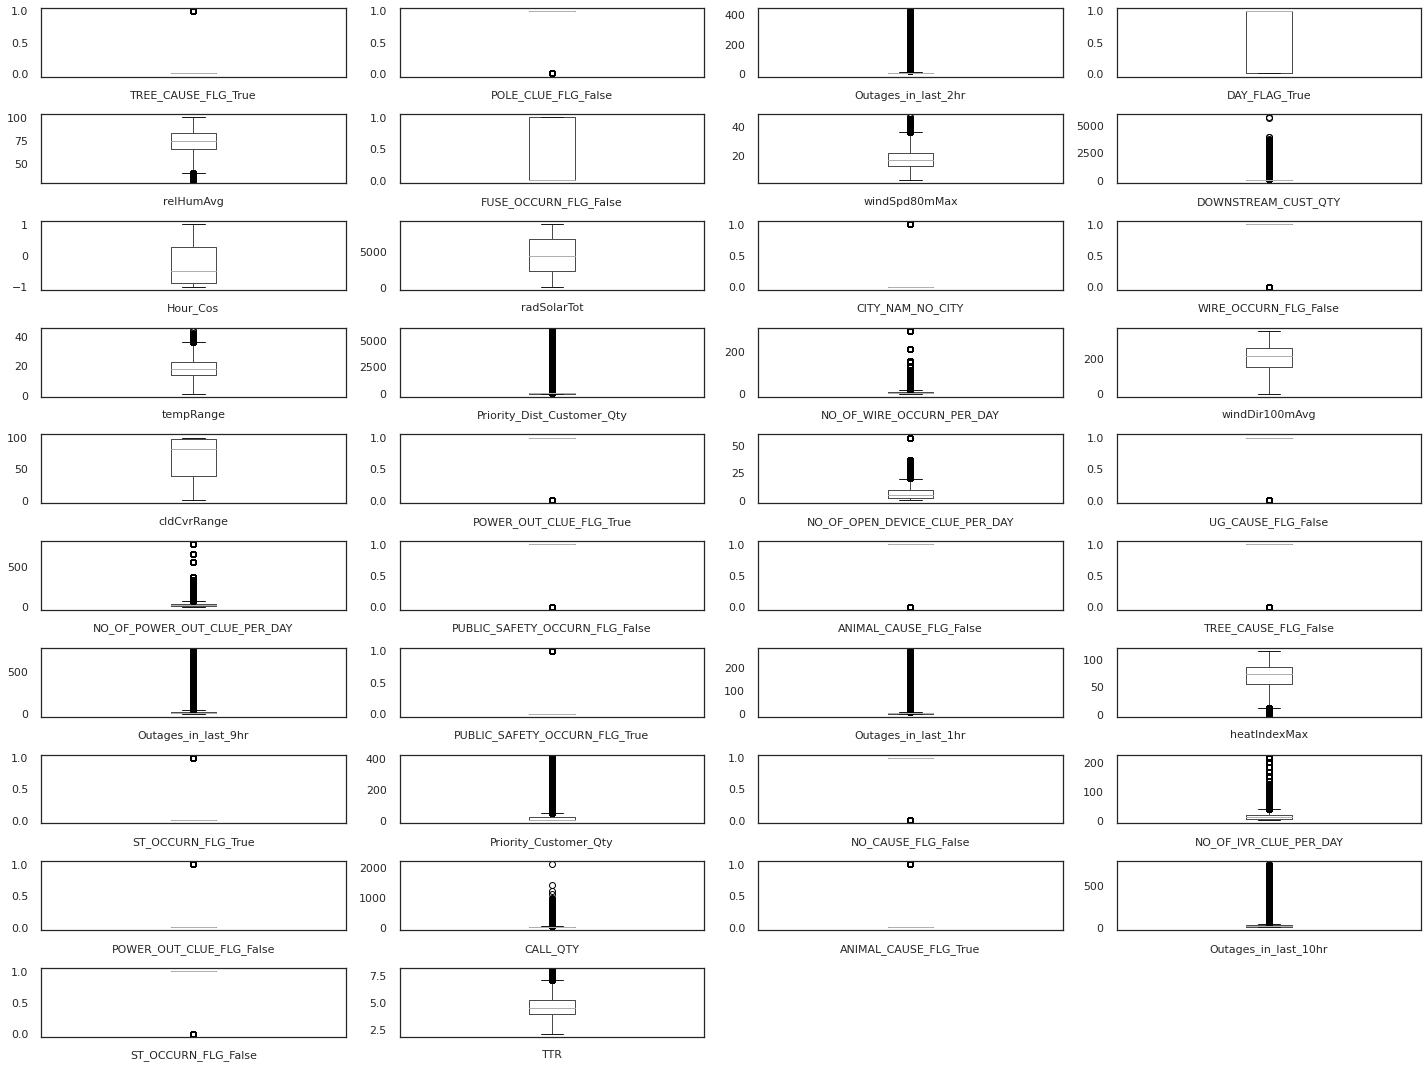

In [27]:
sns.set(rc={'figure.figsize':(20,15)})
sns.set_style("white")
for i, col in enumerate(list(ads_v1.columns.values)):
    plt.subplot(10,4,i+1)
    ads_v1.boxplot(col)
    plt.grid()
    plt.tight_layout()

#### **Check distribution of selected Variables**

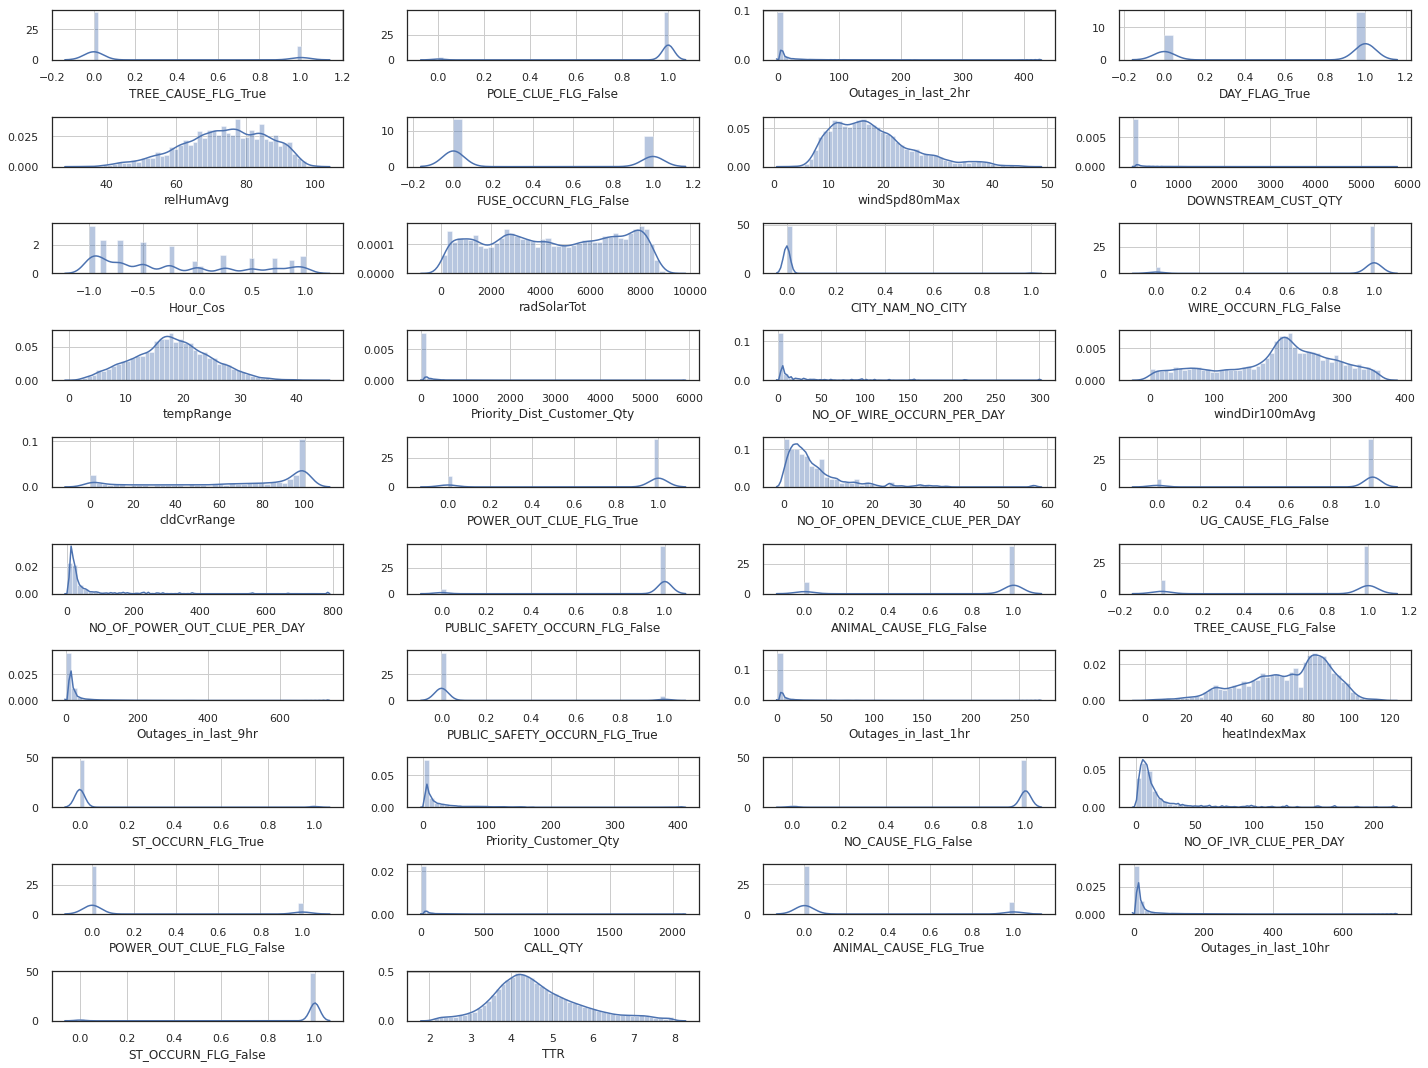

In [28]:
sns.set(rc={'figure.figsize':(20,15)})
sns.set_style("white")
for i, col in enumerate(list(ads_v1.columns.values)):
    plt.subplot(10,4,i+1)
    sns.distplot(ads_v1[col], color='b', kde=True, label='data')
    plt.grid()
    plt.tight_layout()

#### **Train-Test Split using sklearn**

In [29]:
X = ads[final_features]
y = ads['TTR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('\n')
print('\n')
print(len(X_train),len(X_test))
print(len(y_train),len(y_test))
print('\n')
print('\n')

#### **Building Baseline Random Forest Model**
- A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting
- The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [ ]:
model_col = ['MODEL_NAME' , 'TRAIN_MSE', 'TRAIN_RMSE', 'TRAIN_MAE', 'TRAIN_MAPE', 'TRAIN_R2', 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
model_result_df = pd.DataFrame(columns=model_col)
data_train_list = pd.DataFrame() 
data_test_list = pd.DataFrame() 
i=0

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42)

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_train_pred = np.exp(y_train_pred)

y_test_pred = rf.predict(X_test)
y_test_pred = np.exp(y_test_pred)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
r2_train = r2_score(y_train,y_train_pred)
                   
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test,y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)
r2_test = r2_score(y_test,y_test_pred)

data_train = pd.DataFrame({'Model':'Random Forest Baseline', 'Train_Predicted': list(y_train_pred),'Train_Actual': list(y_train) })
data_train_list = data_train_list.append(data_train)
data_train_list.reset_index(drop=True, inplace=True)

data_test = pd.DataFrame({'Model':'Random Forest Baseline', 'Train_Predicted': list(y_test_pred),'Train_Actual': list(y_test)})
data_test_list = data_test_list.append(data_test)
data_test_list.reset_index(drop=True, inplace=True)

model_result_df.loc[i] = ['Random Forest Baseline', mse_train, rmse_train, mae_train, mape_train, r2_train, mse_test, rmse_test, mae_test, mape_test, r2_test]
i = i + 1

#### **Random Forest Parameters**
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [34]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [35]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print('\n')
print('\n')
pprint(random_grid)
print('\n')
print('\n')





{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500]}






#### **Random Search Training**
- The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 100 and 3 respectively)
- More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [38]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  4.0min remaining:  4.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.5min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=2)

In [40]:
print('\n')
print("Best Paramters for Random Forest Model using Random Search:")
print(rf_random.best_params_)



Best Paramters for Random Forest Model using Random Search:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


#### **Grid Search with Cross Validation**
- Random search allowed us to narrow down the range for each hyperparameter
- Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try
- We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [None],
    'max_features': ['auto'],
    'min_samples_leaf': [1.5, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [175, 200, 250, 300, 350]}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

print("Best Paramters for Random Forest Model using Grid Search:")
print(grid_search.best_params_)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 15.4min finished


Best Paramters for Random Forest Model using Grid Search:
{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 300}


In [43]:
grid_search.best_estimator_

RandomForestRegressor(min_samples_leaf=2, min_samples_split=3, n_estimators=300)

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

In [ ]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################
# Enter Regression Model Names

rf = RandomForestRegressor(n_jobs=-1)
xgb = xgb.XGBRegressor(n_jobs=-1)

models= [('random forest', rf), ('xgboost', xgb)]

In [ ]:
# Define model and other needed metrics using a dataframe
# model result structure
# Store the all iteration results 

model_col = ['MODEL_NAME' , 'TEST_MSE', 'TEST_RMSE', 'TEST_MAE', 'TEST_MAPE', 'TEST_R2']
model_result_df = pd.DataFrame(columns=model_col)
data_list = pd.DataFrame() 

X = ads[final_features]
y = ads['TTR']


j=0
for i,model in models:
    print(i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = None
    y_pred = model.predict(X_test)
    
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test,y_pred))
    mae_test = mean_absolute_error(y_test, y_pred)
    mape_test = mean_absolute_percentage_error(y_test,y_pred)
    r2_test = r2_score(y_test,y_pred)

    mse_test = mean_squared_error(y_test, y_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test,y_pred))
    mae_test = mean_absolute_error(y_test, y_pred)
    mape_test = mean_absolute_percentage_error(y_test,y_pred)
    r2_test = r2_score(y_test,y_pred)

    data_val = pd.DataFrame({'Model':str(i), 'Train_Predicted': list(y_pred),'Test_Actual': list(y_test), 'Test_Predicted': list(y_pred),'Test_Actual': list(y_test)})
    data_list = data_list.append(data_val)
    data_list.reset_index(drop=True, inplace=True)
    
    row = [str(i), mse_test, rmse_test, mae_test, mape_test, r2_test]
    model_result_df.loc[j] = row
    
    j = j + 1

In [ ]:
display(model_result_df)

In [ ]:
data_list.Model.value_counts()

In [ ]:
data_list['Predicted'] = pd.to_numeric(data_list['Predicted'], errors='coerce')

In [ ]:
ax = sns.regplot(x="Actual", y="Predicted", data=data_list[data_list.Model=='random forest'], color="g")
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted : Random Forest')

In [ ]:
ax = sns.regplot(x="Actual", y="Predicted", data=data_list[data_list.Model=='xgboost'], color="g")
ax.set_xlim(0,3000)
ax.set_ylim(0,4000)
ax.set_title('Actual vs Fitted : XGBoost')

In [ ]:
residuals
qq plot

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 45, num = 3)]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

pprint(random_grid)